In [236]:
from HTML import config as Config
from HTML.dataset import *
from HTML.config import ratio, nominal, ordinal, meaningless
from HTML.preprocessing import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
df_train = pd.read_csv(Config.train_path)
df_train.head()

,ID,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,-6.305161,0,0,Check-Out,2015-07-01
1,1,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,75.052227,0,0,Check-Out,2015-07-03
2,2,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,74.546401,0,0,Check-Out,2015-07-03
3,3,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,76.376288,0,0,Check-Out,2015-07-03
4,4,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,49.411647,0,0,Check-Out,2015-07-03


In [238]:
df_train.shape

(91531, 33)

In [239]:
df_train = preprocessing(df_train)

In [240]:
df_train.shape

(91527, 33)

In [241]:
fact = pd.factorize(df_train['reservation_status'])
y_train_res = fact[0]
y_train_adr = df_train[df_train['adr'] < 5000]['adr'].to_numpy()

In [242]:
from sklearn.preprocessing import OneHotEncoder

In [243]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [280]:
categories = df_train[sorted(list(set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].astype(str).to_numpy()
cat = enc.fit_transform(categories)

In [281]:
cat.shape

(91527, 941)

In [282]:
num = df_train[sorted(list(set(df_train.columns) - set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].to_numpy()

In [283]:
num.shape

(91527, 13)

In [284]:
tmp = np.concatenate((cat, num), axis=1)
x_train_res = tmp.copy()
x_train_adr = tmp[df_train['adr'] < 5000,:].copy()

In [285]:
# dummies = pd.get_dummies(
#         data=df_train[set(df_train.columns) - {'reservation_status', 'reservation_status_date', 'is_canceled'}],
#         columns=set(nominal+ordinal) - {'reservation_status', 'reservation_status_date', 'is_canceled'},
#         drop_first=True,
#         dummy_na=True)
# dummies = dummies[sorted(set(dummies.columns) - {'index', 'ID'} - set(meaningless))]
# x_train_res = dummies[sorted(list(set(dummies.columns) - {'adr'}))].to_numpy()
# x_train_adr = dummies[dummies['adr'] < 5000][sorted(list(set(dummies.columns) - {'adr'}))].to_numpy()

In [286]:
print('adr:', x_train_adr.shape, y_train_adr.shape)
print('res:', x_train_res.shape, y_train_res.shape)

adr: (91526, 954) (91526,)
res: (91527, 954) (91527,)


In [287]:
from xgboost import XGBClassifier, XGBRegressor

In [288]:
regr = XGBRegressor(
    n_estimators=100,
    learning_rate=.3,
    max_depth=6,
    subsample=1,
    n_jobs=6,
    colsample_bytree=.7,
    random_state=1126,
    gamma=10
)
regr.fit(x_train_adr, y_train_adr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=1126,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [289]:
clf = XGBClassifier(
    objective='multi:prob',
    n_estimators=10,
    learning_rate=.3,
    max_depth=6,
    subsample=.3,
    n_jobs=6,
    colsample_bytree=.9,
    random_state=1126,
    gamma=10,
    num_class=2
)
clf.fit(x_train_res, y_train_res)

/home/jacky/.pyenv/versions/html-3.7.6/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:12:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=6, num_class=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=1126, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [290]:
pred_adr = regr.predict(x_train_adr)
prob_res = clf.predict_proba(x_train_adr)

In [291]:
pred_res = 1 - prob_res[:,0].copy()

In [292]:
pred_res

array([0.37321138, 0.25274855, 0.37537652, ..., 0.07865852, 0.08821869,
       0.10653806], dtype=float32)

In [293]:
tmp = clf.predict(x_train_adr)

In [294]:
new_df_train = df_train[df_train['adr'] < 5000].copy().reset_index()
new_df_train['revenue'] = new_df_train['adr'] * np.sum(new_df_train[['stays_in_weekend_nights', 'stays_in_week_nights']], axis=1) * (1-new_df_train['is_canceled'])
new_df_train['pred_adr'] = pred_adr
# new_df_train['pred_is_canceled'] = (tmp != 0).astype(float)
new_df_train['pred_is_canceled'] = pred_res
new_df_train['pred_revenue'] = new_df_train['pred_adr'] * np.sum(new_df_train[['stays_in_weekend_nights', 'stays_in_week_nights']], axis=1) * (1-new_df_train['pred_is_canceled'])
new_df_train[['revenue', 'pred_revenue']].head()

,revenue,pred_revenue
0,-0.000000,0.000000
1,150.104454,68.195241
2,149.092802,91.994983
3,152.752575,91.994983
4,98.823294,91.994983


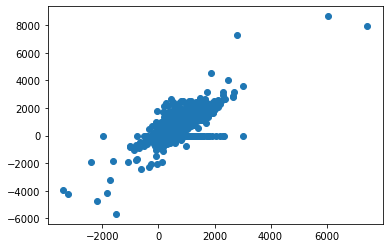

In [295]:
plt.scatter(new_df_train['pred_revenue'], new_df_train['revenue'])
plt.show()

In [296]:
np.mean((new_df_train['revenue'] - new_df_train['pred_revenue']).to_numpy() ** 2)

23414.276072862613

In [297]:
new_df_train = add_arrival_date(new_df_train)

In [298]:
new_df_train_sum = new_df_train.groupby('arrival_date').sum()

In [299]:
new_df_train_sum.head()

,index,ID,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,revenue,pred_adr,pred_is_canceled,pred_revenue
arrival_date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,7381,7381,19,22783,245830,3294,122,45,335,223,...,9,33,0,8490.218248,4,39,20311.186621,8663.113281,45.041138,17390.947003
2015-07-02,15624,15624,57,14241,187395,2511,186,75,291,186,...,3,4,0,5938.812547,5,38,16530.645277,5829.162598,53.539928,15652.553765
2015-07-03,13580,13580,19,4080,112840,1512,168,53,187,112,...,0,6,0,4709.476079,7,27,12966.714164,4594.839355,17.732218,13083.151164
2015-07-04,27676,27676,43,13637,177320,2376,352,164,275,171,...,0,8,0,6301.681498,7,45,17480.654256,6584.820801,50.991840,14599.255998
2015-07-05,20405,20405,16,4433,106795,1484,265,121,195,103,...,0,11,0,4807.284096,13,24,19591.458478,5317.511230,17.063648,19411.313094


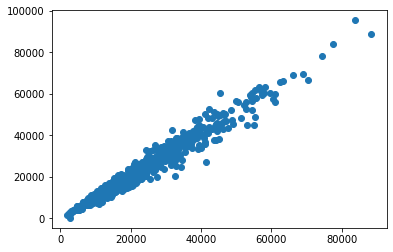

In [300]:
plt.scatter(new_df_train_sum['pred_revenue'], new_df_train_sum['revenue'])
plt.show()

In [301]:
np.mean((new_df_train_sum['revenue'] - new_df_train_sum['pred_revenue']).to_numpy() ** 2)

9039345.215140134

In [302]:
y_train = pd.read_csv(Config.train_label_path)
train = new_df_train_sum.merge(y_train, left_index=True, right_on='arrival_date')

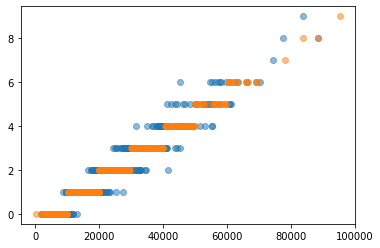

In [303]:
plt.scatter(train['pred_revenue'], train['label'], alpha=.5)
plt.scatter(train['revenue'], train['label'], alpha=.5)
plt.show()

In [304]:
df_test = pd.read_csv(Config.test_path)
df_test.head()

,ID,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,91531,City Hotel,75,2017,April,13,1,2,5,2,...,D,D,0,No Deposit,9.0,NaN,0,Transient,0,1
1,91532,City Hotel,208,2017,April,13,1,4,10,2,...,A,A,0,No Deposit,9.0,NaN,0,Transient,0,1
2,91533,Resort Hotel,12,2017,April,13,1,2,5,2,...,A,A,0,No Deposit,40.0,NaN,0,Contract,0,1
3,91534,City Hotel,76,2017,April,13,1,2,5,3,...,D,D,0,No Deposit,9.0,NaN,0,Transient,0,0
4,91535,City Hotel,9,2017,April,13,1,2,4,2,...,F,F,0,No Deposit,9.0,NaN,0,Transient,0,0


In [305]:
df_test.shape

(27859, 29)

In [306]:
categories = df_test[sorted(list(set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].astype(str).to_numpy()
cat = enc.transform(categories)

In [307]:
cat.shape

(27859, 941)

In [308]:
num = df_test[sorted(list(set(df_test.columns) - set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].to_numpy()

In [309]:
num.shape

(27859, 13)

In [310]:
tmp = np.concatenate((cat, num), axis=1)
x_test = tmp.copy()

In [311]:
print('test:', x_test.shape)

test: (27859, 954)


In [312]:
pred_adr = regr.predict(x_test)
prob_res = clf.predict_proba(x_test)

In [313]:
pred_res = 1- prob_res[:,0].copy()

In [314]:
pred_res

array([0.3304512 , 0.45915854, 0.3264494 , ..., 0.2630936 , 0.0774318 ,
       0.11267251], dtype=float32)

In [315]:
tmp = clf.predict(x_test)

In [340]:
new_df_test = df_test.copy().reset_index()
new_df_test['pred_adr'] = pred_adr
# new_df_test['pred_is_canceled'] = (tmp != 0).astype(float)
new_df_test['pred_is_canceled'] = pred_res
new_df_test['pred_revenue'] = new_df_test['pred_adr'] * np.sum(new_df_test[['stays_in_weekend_nights', 'stays_in_week_nights']], axis=1) * (1-new_df_test['pred_is_canceled'])
new_df_test[['pred_adr', 'pred_is_canceled', 'pred_revenue']].head()

,pred_adr,pred_is_canceled,pred_revenue
0,106.176231,0.330451,497.631185
1,50.756371,0.459159,384.316094
2,72.290970,0.326449,340.841386
3,127.737000,0.736109,235.960549
4,192.197525,0.655807,396.917685


In [342]:
new_df_test[['pred_adr', 'pred_is_canceled', 'pred_revenue']].describe()

,pred_adr,pred_is_canceled,pred_revenue
count,27859.000000,27859.000000,27859.000000
mean,100.431442,0.388902,218.055493
std,44.444550,0.296699,219.610459
min,-52.252293,0.035430,-736.467024
25%,73.499130,0.127105,80.061305
50%,96.364334,0.326151,161.462610
75%,123.372730,0.652852,287.201120
max,336.267792,0.979969,3381.900593


In [318]:
new_df_test = add_arrival_date(new_df_test)

In [319]:
new_df_test_sum = new_df_test.groupby('arrival_date').sum()

In [320]:
new_df_test_sum.head()

,index,ID,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,pred_adr,pred_is_canceled,pred_revenue
arrival_date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,8646,12090738,12575,266244,1716,132,225,299,273,20.0,...,7,25,15944.0,163.0,205,7,79,12571.656250,43.669472,30392.908932
2017-04-02,17232,8804208,7043,193632,1344,192,186,181,187,8.0,...,10,29,5736.0,301.0,63,5,112,9347.386719,29.957003,23326.407192
2017-04-03,79233,21222894,17786,465927,3234,693,251,513,407,19.0,...,19,51,10799.0,5482.0,211,9,120,19404.341797,92.718262,37271.302628
2017-04-04,65125,11506500,13068,252125,1750,500,26,355,239,19.0,...,31,39,7435.0,14441.0,32,7,63,10155.100586,66.475464,16610.248061
2017-04-05,178794,23244606,30182,508284,3528,1260,54,824,429,13.0,...,40,186,13759.0,25140.0,345,17,73,14248.525391,88.749786,29499.712056


In [338]:
new_df_test_sum['pred_revenue'].describe()

count      153.000000
mean     39704.627375
std      13162.305160
min      14958.994418
25%      30342.657231
50%      37271.302628
75%      46161.786468
max      86188.207975
Name: pred_revenue, dtype: float64

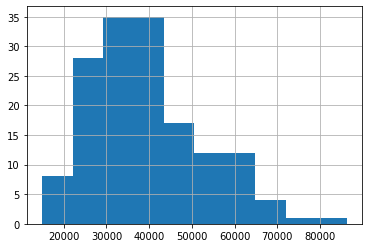

In [337]:
new_df_test_sum['pred_revenue'].hist()
plt.show()

In [328]:
test_index = new_df_test_sum.index

In [344]:
label = np.floor(new_df_test_sum['pred_revenue'].to_numpy() / 10000)

In [346]:
from HTML.save import save_prediction
save_prediction('../outputs//xgboost2.csv', test_index, label)